In [1]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

In [2]:
#Python-related imports
import math, sys
from typing import Dict, Tuple, Union
from datetime import datetime
import os.path

#Torch-related imports
import torch
from torch.autograd import Function
from torch import nn
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim

#Module imports
from SBM_SDE_classes import *
from obs_and_flow import *
from training import *
from plotting import *
from mean_field import *
from TruncatedNormal import *
from LogitNormal import *

In [3]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import time

In [4]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

#Neural SDE parameters
dt_flow = 1.0 #Increased from 0.1 to reduce memory.
t = 1000 #In hours.
n = int(t / dt_flow) + 1
t_span = np.linspace(0, t, n)
t_span_tensor = torch.reshape(torch.Tensor(t_span), [1, n, 1]).to(active_device) #T_span needs to be converted to tensor object. Additionally, facilitates conversion of I_S and I_D to tensor objects.

#SBM temperature forcing parameters
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

#Specify desired SBM SDE model type and details.
state_dim_SCON = 3 #Not including CO2 in STATE_DIM, because CO2 is an observation.
SBM_SDE_class = 'SCON'
diffusion_type = 'C'
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'

#Load logit-normal priors
priors_file = '../generated_data/SCON-C_CO2_fix_x_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_hyperparams.pt'
SCON_C_priors_details = {k: v.to(active_device) for k, v in torch.load(priors_file).items()}

#Initial condition prior means
x0_error_scale = 0.1
x0_SCON = [65, 0.4, 2.5]
x0_SCON_tensor = torch.tensor(x0_SCON).to(active_device)
x0_prior_SCON = D.multivariate_normal.MultivariateNormal(x0_SCON_tensor,
                                                         scale_tril = torch.eye(state_dim_SCON).to(active_device) * x0_error_scale * x0_SCON_tensor)

#Generate exogenous input vectors.
#Obtain temperature forcing function.
temp_tensor = temp_gen(t_span_tensor, temp_ref, temp_rise).to(active_device)

#Obtain SOC and DOC pool litter input vectors for use in flow SDE functions.
i_s_tensor = i_s(t_span_tensor).to(active_device) #Exogenous SOC input function
i_d_tensor = i_d(t_span_tensor).to(active_device) #Exogenous DOC input function

#Generate observation model.
x_path = os.path.join('../generated_data/', 'SCON-C_CO2_fix_x_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_x.pt')

In [5]:
#class MeanField(nn.Module):
#
#    '''
#    Class for mean-field variational inference of SBM SDE parameters.
#    Takes dictionary of parameter distribution information in order of mean, sdev, upper bound, and lower bound.
#
#    The forward method returns dict_out, samples, log_q_theta, dict_parent_loc_scale.
#    dict_out: dictionary of theta samples corresponding to their parameter keys for debugging and printing.
#    samples: tensor of the theta values themselves for inference use.
#    log_q_theta: log probability of the theta values corresponding to the variational distribution.
#    dict_parent_loc_scale: dictionary of the values of the parent loc and scale distribution parameters.
#
#    Formerly, the forward method returned dict_mean_sd, a dictionary of the values of the transformed distribution means and standard deviations, but calculation of the distribution mean and standard deviation was computationally wasteful to compute at every iteration and simpler for the TruncatedNormal distribution class than RescaledLogitNormal. The means and standard deviations can be computed from dict_parent_loc_scale.
#    '''
#
#    def __init__(self, DEVICE, PARAM_NAMES, INIT_DICT, DIST_CLASS, LEARN_COV=False):
#        super().__init__()
#        #Use param dict to intialise the means for the mean-field approximations.
#        #init_params: name -> (parent mean, parent sd, true lower, true upper)
#        means = []
#        sds = []
#        lower_bounds = []        
#        upper_bounds = []
#        for key in PARAM_NAMES:
#            mean, sd, lower, upper = INIT_DICT[key]
#            means.append(mean)
#            sds.append(sd)
#            upper_bounds.append(upper)
#            lower_bounds.append(lower)
#
#        self.dist = DIST_CLASS
#        self.learn_cov = LEARN_COV
#        self.means = nn.Parameter(torch.Tensor(means).to(DEVICE))
#        if LEARN_COV:
#            # Since we init post with indep priors, scale_tril = diag(stddev)
#            scale_tril = torch.diag(torch.Tensor(sds)).to(DEVICE)
#            # Map scale_tril to unconstrained space
#            unconstrained_scale_tril = D.transform_to(self.dist.arg_constraints['scale_tril']).inv(scale_tril)
#            self.sds = nn.Parameter(unconstrained_scale_tril) # (num_params, num_params)
#        else:
#            #scale = torch.Tensor(sds).to(DEVICE)
#            #unconstrained_scale = D.transform_to(self.dist.arg_constraints['scale']).inv(scale)
#            #self.sds = nn.Parameter(unconstrained_scale)
#            self.sds = nn.Parameter(torch.Tensor(sds).to(DEVICE)) # (num_params, )
#        self.lowers = torch.Tensor(lower_bounds).to(DEVICE)
#        self.uppers = torch.Tensor(upper_bounds).to(DEVICE)
#        
#        #Save keys for forward output.
#        self.keys = PARAM_NAMES
#
#    def forward(self, N = 10): # N should be assigned batch size in `train` function from training.py.
#        #Update posterior.
#        parent_loc = self.means
#        if self.learn_cov:
#            parent_scale_tril = D.transform_to(self.dist.arg_constraints['scale_tril'])(self.sds)
#            parent_scale = torch.diag(parent_scale_tril) # this is incorrect unless indep, but not used in inference
#            q_dist = self.dist(parent_loc, scale_tril=parent_scale_tril, a = self.lowers, b = self.uppers)
#        else:
#            parent_scale = LowerBound.apply(self.sds, 1e-8)
#            #parent_scale = D.transform_to(self.dist.arg_constraints['scale'])(self.sds)
#            q_dist = self.dist(parent_loc, parent_scale, a = self.lowers, b = self.uppers)
#
#        # Sample theta ~ q(theta).
#        samples = q_dist.rsample([N]) # (N, num_params)
#        
#        # Evaluate log prob of theta samples.
#        if self.learn_cov:
#            log_q_theta = q_dist.log_prob(samples) # (N, )
#        else:
#            log_q_theta = torch.sum(q_dist.log_prob(samples), -1) # (N, )
#        
#        # Return samples in same dictionary format.
#        dict_out = {} #Define dictionary with n samples for each parameter.
#        for key, sample in zip(self.keys, torch.split(samples, 1, -1),):
#            dict_out[f'{key}'] = sample.squeeze(1) #Each sample is of shape [n].
#        
#        dict_parent_loc_scale = {} #Define dictionary to store parent parameter normal distribution means and standard deviations.
#        #dict_mean_sd = {} #Define dictionary to store real parameter normal distribution means and standard deviations for TruncatedNormal distribution.
#        #real_loc = q_dist.mean #q_dist._mean
#        #real_scale = q_dist.stddev #torch.sqrt(q_dist._variance)
#        # for key, parent_loc_scale, mean_sd in zip(self.keys, torch.split(torch.stack([parent_loc, parent_scale], 1), 1, 0), torch.split(torch.stack([real_loc, real_scale], 1), 1, 0)):
#        #     dict_parent_loc_scale[f'{key}'] = parent_loc_scale
#        #     dict_mean_sd[f'{key}'] = mean_sd
#        for key, parent_loc_scale in zip(self.keys, torch.split(torch.stack([parent_loc, parent_scale], 1), 1, 0)):
#            dict_parent_loc_scale[f'{key}'] = parent_loc_scale
#        
#        #Return samples in dictionary and tensor format.                                
#        #return dict_out, samples, log_q_theta, dict_parent_loc_scale, dict_mean_sd
#        return dict_out, samples, log_q_theta, dict_parent_loc_scale
#
#        #if self.dist == TruncatedNormal:
#        #    dict_mean_sd = {} #Define dictionary to store real parameter normal distribution means and standard deviations for TruncatedNormal distribution.
#        #    real_loc = q_dist.mean #q_dist._mean
#        #    real_scale = q_dist.stddev #torch.sqrt(q_dist._variance)
#        #    for key, loc_scale, mean_sd in zip(self.keys, torch.split(torch.stack([parent_loc, parent_scale], 1), 1, 0), torch.split(torch.stack([real_loc, real_scale], 1), 1, 0)):
#        #        dict_parent_loc_scale[f'{key}'] = loc_scale
#        #        dict_mean_sd[f'{key}'] = mean_sd
#        #    #Return samples in dictionary and tensor format.                                
#        #    return dict_out, samples, log_q_theta, dict_parent_loc_scale, dict_mean_sd
#
#        #elif self.dist == RescaledLogitNormal:
#        #    for key, loc_scale in zip(self.keys, torch.split(torch.stack([parent_loc, parent_scale], 1), 1, 0)):
#        #        dict_parent_loc_scale[f'{key}'] = loc_scale
#        #    #Return samples in dictionary and tensor format.                
#        #    return dict_out, samples, log_q_theta, dict_parent_loc_scale  

In [6]:
def calc_log_lik(C_PATH, PARAMS_DICT, DT, SBM_SDE_CLASS, INIT_PRIOR):

    drift, diffusion_sqrt = SBM_SDE_CLASS.drift_diffusion(C_PATH, PARAMS_DICT) #Appropriate indexing of tensors corresponding to data generating process now handled in `drift_diffusion` class method. Recall that drift diffusion will use C_PATH[:, :-1, :], I_S_TENSOR[:, 1:, :], I_D_TENSOR[:, 1:, :], TEMP_TENSOR[:, 1:, :]. 
    euler_maruyama_state_sample_object = D.multivariate_normal.MultivariateNormal(loc = C_PATH[:, :-1, :] + drift * DT, scale_tril = diffusion_sqrt * math.sqrt(DT)) #C_PATH[:, :-1, :] + drift * DT will diverge from C_PATH if C_PATH values not compatible with x0 and theta. Algorithm aims to minimize gap between computed drift and actual gradient between x_n and x_{n+1}. 

    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = euler_maruyama_state_sample_object.log_prob(C_PATH[:, 1:, :]).sum(-1) # log p(x|x0, theta)
    ll += INIT_PRIOR.log_prob(C_PATH[:, 0, :]) # log p(x0|theta)

    return ll, drift, diffusion_sqrt

def train(DEVICE, LR, NITER, BATCH_SIZE, X_FILE, T, DT, N,
        T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF,
        SBM_SDE_CLASS, DIFFUSION_TYPE, X0_PRIOR, PRIOR_DIST_DETAILS_DICT, 
        THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
        LR_DECAY = 0.8, DECAY_STEP_SIZE = 50000, PRINT_EVERY = 100):
    torch.manual_seed(0)
    
    # Instantiate SBM_SDE object based on specified model and diffusion type.
    SBM_SDE_class_dict = {
            'SCON': SCON,
            'SAWB': SAWB,
            'SAWB-ECA': SAWB_ECA
            }
    if SBM_SDE_CLASS not in SBM_SDE_class_dict:
        raise NotImplementedError('Other SBM SDEs aside from SCON, SAWB, and SAWB-ECA have not been implemented yet.')
    SBM_SDE_class = SBM_SDE_class_dict[SBM_SDE_CLASS]
    SBM_SDE = SBM_SDE_class(T_SPAN_TENSOR, I_S_TENSOR, I_D_TENSOR, TEMP_TENSOR, TEMP_REF, DIFFUSION_TYPE)

    # Load x, exclude CO2 and extra time steps 
    # (since data generation process uses smaller dt than dt_flow)
    x_all = torch.load(X_FILE)
    step = (x_all.shape[1] - 1) // (N - 1)
    x = torch.tensor(x_all[:SBM_SDE.state_dim, ::step], dtype=torch.float)
    x = x.T.expand(BATCH_SIZE, -1, -1)
    assert x.shape == (BATCH_SIZE, N, SBM_SDE.state_dim)

    # Convert prior details dictionary values to tensors.
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    # Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    # Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training
    best_loss = 1e15
    losses = []

    #Initiate optimizers.
    optimizer = optim.Adamax(list(q_theta.parameters()), lr = LR)
    
    #Training loop
    with tqdm(total = NITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(1, NITER + 1):
            optimizer.zero_grad()                
            
            # Sample theta ~ q(theta) and compute log q(theta)
            theta_dict, theta, log_q_theta, _ = q_theta(BATCH_SIZE)
            
            # Compute log p(theta)
            log_p_theta = p_theta.log_prob(theta).sum(-1)

            # Compute log p(x|theta)
            log_lik, drift, diffusion_sqrt = calc_log_lik(x, theta_dict, DT, SBM_SDE, X0_PRIOR)

            # Compute negative ELBO: -(log p(theta) + log p(x|theta) - log q (theta))
            loss = -log_p_theta.mean() - log_lik.mean() + log_q_theta.mean()
            best_loss = loss if loss < best_loss else best_loss
            losses.append(loss.item())

            if it % PRINT_EVERY == 0:
                print('Iteration {} loss: {}'.format(it, loss))

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(ELBO_params, 5.0)
            optimizer.step()
        
            if it % DECAY_STEP_SIZE == 0:
                optimizer.param_groups[0]['lr'] *= LR_DECAY

            tq.update()
    
    return q_theta, p_theta, losses

In [7]:
#Training parameters
niter = 2000
train_lr = 0.01 #ELBO learning rate
batch_size = 40 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.

In [8]:
#Call training loop function for SCON-C.
q_theta_raw, p_theta, losses = train(
        active_device, train_lr, niter, batch_size, x_path, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, x0_prior_SCON, SCON_C_priors_details,
        THETA_DIST=theta_dist, THETA_POST_DIST=theta_post_dist,
        LR_DECAY = 1.0, PRINT_EVERY = 100)

Iteration 100 loss: -604.718994140625
Iteration 200 loss: -617.9058227539062
Iteration 300 loss: -620.8978271484375
Iteration 400 loss: -626.7957763671875
Iteration 500 loss: -631.0901489257812
Iteration 600 loss: -631.0729370117188
Iteration 700 loss: -629.9344482421875
Iteration 800 loss: -633.117919921875
Iteration 900 loss: -634.3644409179688
Iteration 1000 loss: -635.581787109375
Iteration 1100 loss: -635.8483276367188
Iteration 1200 loss: -635.4344482421875
Iteration 1300 loss: -635.3072509765625
Iteration 1400 loss: -635.2507934570312
Iteration 1500 loss: -635.889404296875
Iteration 1600 loss: -635.9729614257812
Iteration 1700 loss: -636.1976318359375
Iteration 1800 loss: -636.6226196289062
Iteration 1900 loss: -636.1403198242188
Iteration 2000 loss: -636.5632934570312



In [9]:
#Call training loop function for SCON-C.
q_theta_raw_mf, p_theta_mf, losses_mf = train(
        active_device, train_lr, niter, batch_size, x_path, t, dt_flow, n, 
        t_span_tensor, i_s_tensor, i_d_tensor, temp_tensor, temp_ref,
        SBM_SDE_class, diffusion_type, x0_prior_SCON, SCON_C_priors_details,
        THETA_DIST=theta_dist, THETA_POST_DIST=theta_dist,
        LR_DECAY = 1.0, PRINT_EVERY = 100)

Iteration 100 loss: -628.090576171875
Iteration 200 loss: -633.5919189453125
Iteration 300 loss: -635.2605590820312
Iteration 400 loss: -635.9464111328125
Iteration 500 loss: -635.8938598632812
Iteration 600 loss: -635.7667846679688
Iteration 700 loss: -635.8280029296875
Iteration 800 loss: -635.5293579101562
Iteration 900 loss: -636.0074462890625
Iteration 1000 loss: -636.208740234375
Iteration 1100 loss: -636.0269775390625
Iteration 1200 loss: -635.704833984375
Iteration 1300 loss: -635.624267578125
Iteration 1400 loss: -635.1155395507812
Iteration 1500 loss: -635.5352172851562
Iteration 1600 loss: -635.033203125
Iteration 1700 loss: -635.6621704101562
Iteration 1800 loss: -635.2320556640625
Iteration 1900 loss: -635.0747680664062
Iteration 2000 loss: -635.430419921875



## Visualizations

In [10]:
def plot_loss(loss_hist_list, labels, time_hist_list=None, xscale='linear', ymin=None, ymax=None):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    
    for loss_hist, label in zip(loss_hist_list, labels):
        plt.plot(loss_hist, label=label)
    
    plt.xlabel('iteration')
    plt.title('Loss v iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.ylim((ymin, ymax))

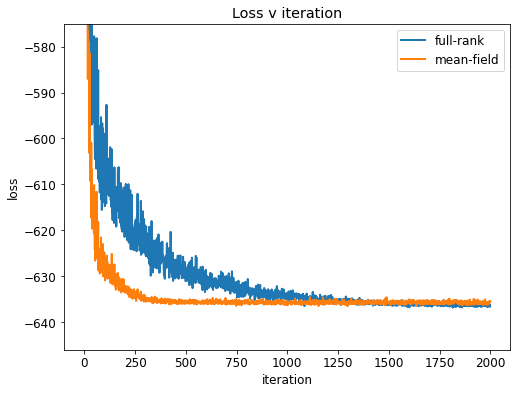

In [11]:
labels = ['full-rank', 'mean-field']
plot_loss([losses, losses_mf], labels, ymax=-575)

In [12]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones_like(q.sds) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [13]:
q_theta = extract_dist(q_theta_raw)
q_theta_mf = extract_dist(q_theta_raw_mf)

In [14]:
def plot_theta(p_theta, q_theta_list, theta_file, labels, param_names, num_pts=1000, eps=1e-5, ncols=4,
               colors=None, linestyles=None):
    plt.rcParams.update({'font.size': 16, 'lines.linewidth': 2})
    
    # Load posterior and define plot boundaries
    a, b = p_theta.a, p_theta.b
    x0 = p_theta.mean - 4*p_theta.stddev
    x1 = p_theta.mean + 4*p_theta.stddev
    q_marginals = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, RescaledLogitNormal):
            q_marginal = q_theta
        else:
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        q_marginals.append(q_marginal)
        x0 = torch.fmin(x0, q_marginal.mean - 4*q_marginal.stddev)
        x1 = torch.fmax(x1, q_marginal.mean + 4*q_marginal.stddev)
        #print(x0, x1)
    x0 = torch.fmax(x0, a).detach()
    x1 = torch.fmin(x1, b).detach()
    x = torch.from_numpy(np.linspace(x0, x1, num_pts))
    
    # Load true theta
    theta = torch.load(theta_file, map_location=device)
    
    # Compute pdfs
    #print(x[0, :], x[-1, :])
    prior_pdf = torch.exp(p_theta.log_prob(x)).detach()
    post_pdfs = []
    for q_theta in q_marginals:
        post_pdf = torch.exp(q_theta.log_prob(x)).detach()
        post_pdfs.append(post_pdf)
    
    # Plot prior v posterior v true theta
    num_params = len(param_names)
    nrows = int(num_params / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = np.atleast_2d(axes)
    k = 0
    if colors is None: colors = [cm.tab10(i+1) for i in range(len(post_pdfs))]
    if linestyles is None: linestyles = ['-'] * len(post_pdfs)
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            if k < num_params:
                key = param_names[k]
                ax.plot(x[:, k], prior_pdf[:, k], label='Prior $p(\\theta)$', color='tab:blue')
                for post_pdf, post_dist, c, l in zip(post_pdfs, labels, colors, linestyles):
                    label = 'Posterior $q(\\theta)$ {}'.format(post_dist)
                    ax.plot(x[:, k], post_pdf[:, k], label=label, color=c, linestyle=l)
                ax.axvline(theta[key], color='gray', label='True $\\theta$')
                ax.set_xlabel(key)
                if j == 0: ax.set_ylabel('density')
            elif k == num_params:
                handles, labels = axes[0, 0].get_legend_handles_labels()
                ax.legend(handles, labels, loc='center')
                ax.axis('off')
            else:
                fig.delaxes(axes[i, j])
            k += 1  
    plt.tight_layout()
    plt.suptitle('Marginal distributions')
    plt.subplots_adjust(top=0.95)
    plt.show()

In [ ]:
theta_file = '../generated_data/SCON-C_CO2_fix_x_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'
plot_theta(p_theta, [q_theta, q_theta_mf], theta_file, labels, q_theta_raw.keys)

In [15]:
def plot_corr(q_theta_list, labels, param_names, num_samples=100000):
    plt.rcParams.update({'font.size': 12})
    
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    fig, axes = plt.subplots(1, num_cols, figsize=(8*num_cols, 8))
    axes = np.atleast_1d(axes)
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(param_names, rotation='vertical')
        ax.set_yticks(range(D))
        ax.set_yticklabels(param_names)
        ax.set_title(labels[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between parameters')
    plt.show()

In [ ]:
plot_corr([q_theta], [None], q_theta_raw.keys)

## Compare with unobserved $x$

In [16]:
q_theta_y_file = '../training_pt_outputs/q_theta_iter_310000_t_1000_dt_1.0_batch_40_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_logit_multi_2021_09_22_11_48_46.pt'
q_theta_y_mf_file = '../training_pt_outputs/q_theta_iter_250000_t_1000_dt_1.0_batch_45_layers_5_lr_0.0005_sd_scale_0.333_SCON-C_no_CO2_logit_alt_2021_09_23_07_08_19.pt'
device=torch.device('cpu')
q_theta_y = extract_dist(torch.load(q_theta_y_file, map_location=device))
q_theta_y_mf = extract_dist(torch.load(q_theta_y_mf_file, map_location=device))

/Users/debora/opt/anaconda3/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'mean_field.MeanField' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


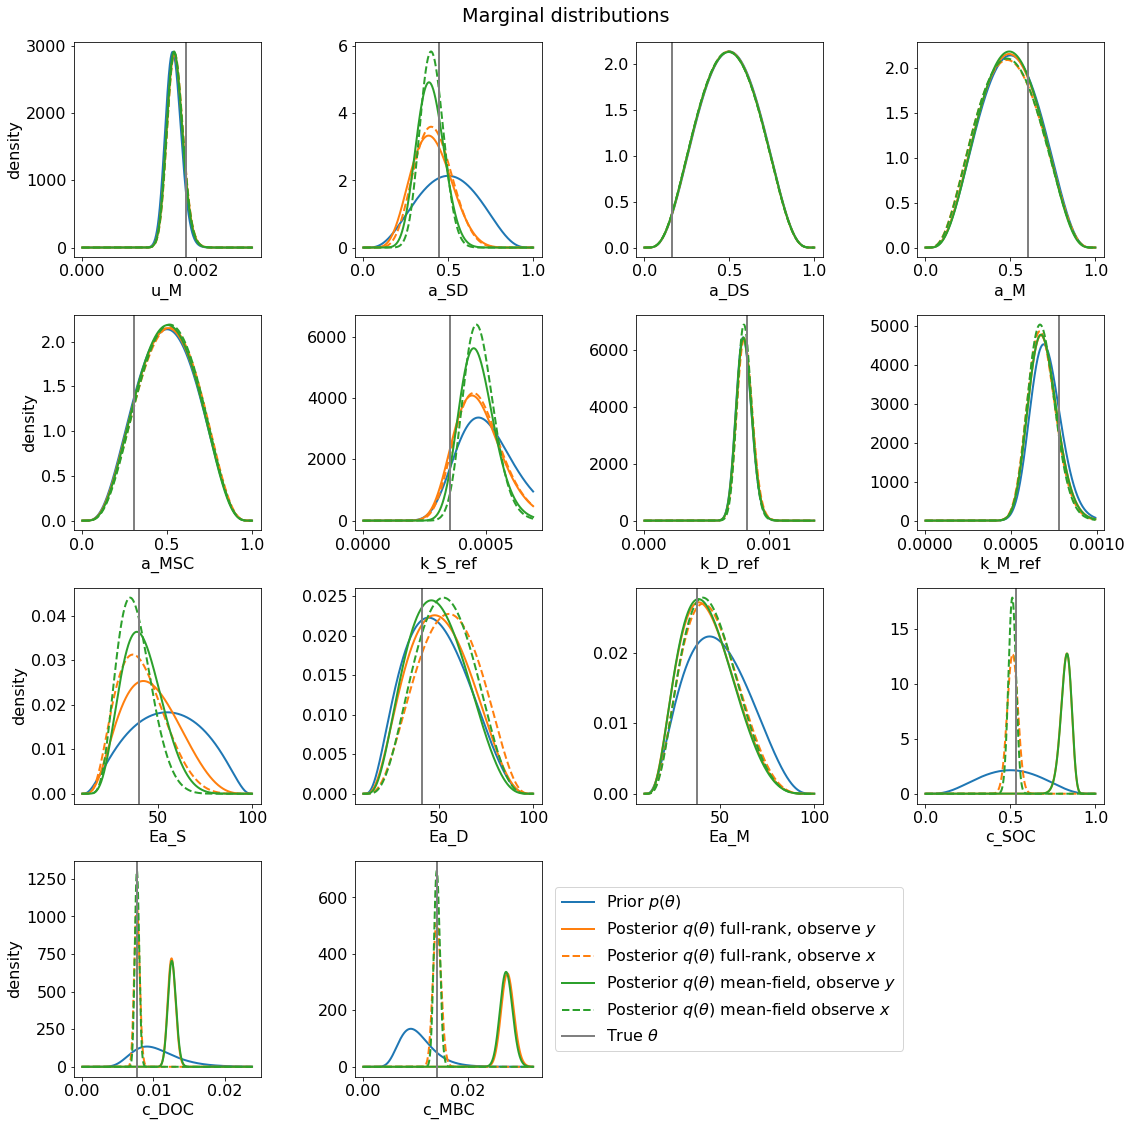

In [17]:
theta_file = '../generated_data/SCON-C_CO2_logit_alt_sample_y_t_1000_dt_0-01_sd_scale_0-333_rsample.pt'
labels = ['full-rank, observe $y$', 'full-rank, observe $x$', 'mean-field, observe $y$', 'mean-field observe $x$']
plot_theta(p_theta, [q_theta_y, q_theta, q_theta_y_mf, q_theta_mf], theta_file, labels, q_theta_raw.keys,
           colors=[cm.tab10(1), cm.tab10(1), cm.tab10(2), cm.tab10(2)], linestyles=['-', '--', '-', '--'])

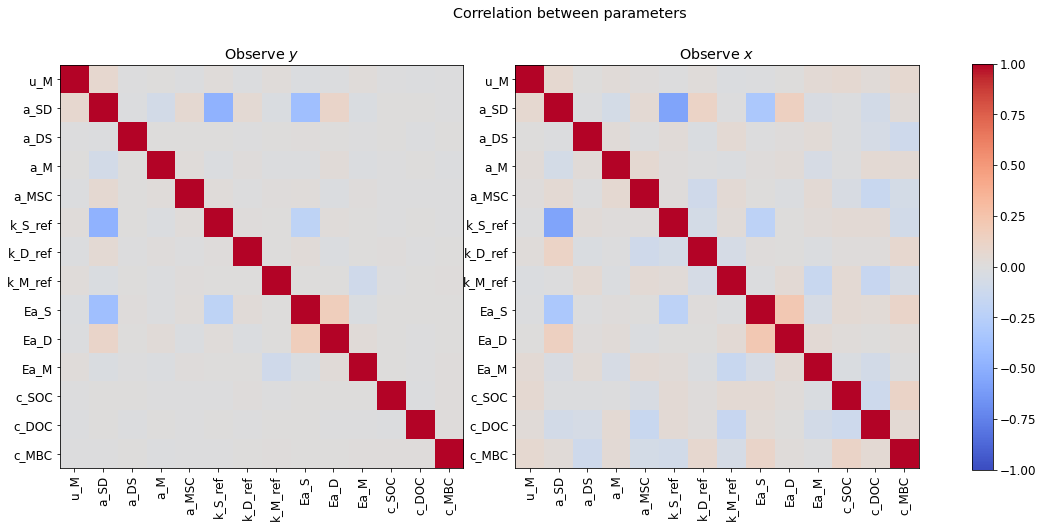

In [18]:
plot_corr([q_theta_y, q_theta], ['Observe $y$', 'Observe $x$'], q_theta_raw.keys)